# Import requirements

In [83]:
import numpy
import pandas as pd
import string
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import pickle
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

# Step 1: Open csv

In [36]:
path_to_csv = "../dataset/Tweets.csv"
dataframe = pd.read_csv(path_to_csv)
dataframe = dataframe[dataframe['airline_sentiment_confidence'] >= 0.75].drop_duplicates()
filtered_df = dataframe.filter(items=["text","airline_sentiment"])
filtered_df 

text airline_sentiment
0                    @VirginAmerica What @dhepburn said.           neutral
3      @VirginAmerica it's really aggressive to blast...          negative
4      @VirginAmerica and it's a really big bad thing...          negative
5      @VirginAmerica seriously would pay $30 a fligh...          negative
9      @VirginAmerica it was amazing, and arrived an ...          positive
...                                                  ...               ...
14631  @AmericanAir thx for nothing on getting us out...          negative
14633  @AmericanAir my flight was Cancelled Flightled...          negative
14636  @AmericanAir leaving over 20 minutes Late Flig...          negative
14637  @AmericanAir Please bring American Airlines to...           neutral
14638  @AmericanAir you have my money, you change my ...          negative

[10425 rows x 2 columns]

# Step 2: Extract phrases and labels

In [50]:
training_phrases = filtered_df["text"].to_numpy()
training_labels = filtered_df["airline_sentiment"].to_numpy()

# Step 3: Plot label distribution

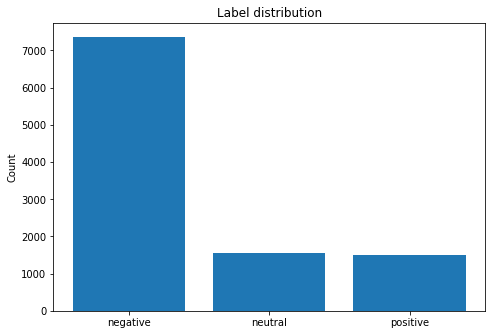

In [51]:
label_dist, label_dist_count = numpy.unique(training_labels, return_counts = True)
label_dist = label_dist.astype("str")

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Count')
ax.set_title('Label distribution')
ax.bar(label_dist,label_dist_count)
plt.show()

# Step 4: Text preprocessor
- lowercase
- remove punctuations
- remove white spaces

In [85]:
def text_preprocessor(training_phrases):
    """
    input: array
    Takes in an array with sentences & cleans the sentences
    output: array """
    clean_tps = []
    for sentence in training_phrases:
        # Lowercase
        sentence = sentence.lower()
        # Remove punctuations
        sentence = sentence.translate(str.maketrans('', '', string.punctuation))
        # Remove white spaces
        sentence = re.sub(' +', ' ',sentence).strip()
        # Append cleaned sentences
        clean_tps.append(sentence)

    return clean_tps

clean_tps = text_preprocessor(training_phrases)

print(f"Before preprocessor:\n{training_phrases[0]}\n\nAfter preprocessor: \n{clean_tps[1]}")

SyntaxError: invalid syntax (4123503161.py, line 8)

# ======================= Featurization =======================

# Step 5: Countvectorizer

In [54]:
vectorizer = CountVectorizer(max_features=5000).fit(clean_tps)
train_features = vectorizer.transform(clean_tps)

(10425, 5000)


# Checkpoint 

In [55]:
print("shape of train_features: {}".format(train_features.shape))
print("example of vectorized training data: {}".format(train_features[0].toarray()))

shape of train_features: (10425, 5000)
example of vectorized training data: [0 0 0 ... 0 0 0]


# Step 6: Split data in train and test

In [74]:
x_train, x_val, y_train, y_val = train_test_split(train_features, 
                                                  training_labels,
                                                  test_size = 0.20, 
                                                  random_state = 1, 
                                                  stratify = training_labels)

# =============== Classification algorithm ===============

# Step 7: SVM model

In [75]:
clf = SVC(kernel='linear', 
          probability=True)

clf.fit(x_train,y_train)
y_pred = clf.predict(x_val)
print(accuracy_score(y_val,y_pred))

0.8551558752997602


# Step 8: Model evaluation

In [77]:
print(classification_report(y_val,y_pred))
print(confusion_matrix(y_val,y_pred))
print()
print(accuracy_score(y_val,y_pred))

              precision    recall  f1-score   support

    negative       0.91      0.91      0.91      1475
     neutral       0.62      0.69      0.65       308
    positive       0.84      0.77      0.80       302

    accuracy                           0.86      2085
   macro avg       0.79      0.79      0.79      2085
weighted avg       0.86      0.86      0.86      2085

[[1340  110   25]
 [  79  211   18]
 [  49   21  232]]

0.8551558752997602


# =============== Save objects to disk ===============
- count vectorizer
- trained model

## Paths

In [86]:
path_to_model = "../models/"
path_to_features = "../featurizers/"
feature_name = 'sparse_features'
model_name = 'svm'

## Save as pickle

In [87]:
def save_as_pickle(obj, dir_name, file_name):
    is_exist = os.path.exists(dir_name)
    if not is_exist:
        os.makedirs(dir_name)
    pickle.dump(obj, open(dir_name+file_name, 'wb'))
    
save_as_pickle(vectorizer, path_to_features, feature_name)
print("feature object is succesfully saved...")
save_as_pickle(clf, path_to_model, model_name)
print("model object is successfully saved...")

feature object is succesfully saved
model object is successfully saved
